In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import ast


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from scipy.stats import zscore


import newspaper
import csv
from datetime import datetime
from datetime import timedelta

import nltk                                         #Natural language processing tool-kit
import re

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from gensim.models import Word2Vec 


import urllib
from urllib.request import urlopen
from urllib import request, parse
from urllib.error import HTTPError
from newspaper import Article, ArticleException
from bs4 import BeautifulSoup
import json



import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.corpus import stopwords
from gensim import models, similarities
from gensim.summarization import keywords

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/ryzhbtc"))
print(os.listdir('../working'))



# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


['ldamodels', 'ryzh-prepared-articles', 'bitcointicker-articles', 'bitcoin-historical-data', 'ryzhbtc', 'bitcointickertransformed']
['Bitcoin Historical Data - Investing.com.csv']
['.ipynb_checkpoints', '__notebook_source__.ipynb']


In [2]:
class BitcoinData:
    data = []
    
    def load(self, path='', filename = "bitstamp"):
        self.data = pd.read_csv(path + '/' + filename)
        self.attributes = list (self.data.columns.values)
        self.data.Date = pd.to_datetime(self.data.Date, format='%b %d, %Y')
        self.data.Price = self.data.Price.str.replace(',', '').astype(float)
        self.data.Open = self.data.Open.str.replace(',', '').astype(float)
        self.data.High = self.data.High.str.replace(',', '').astype(float)
        self.data.Low = self.data.Low.str.replace(',', '').astype(float)
        
        
    
    def resample(self, period = 'd'):
        self.data.index = self.data.Date
        
        # Resampling to daily frequency
        if (period == "d"):
            self.data = self.data.resample('D').mean()
        # Resampling to monthly frequency
        if (period == "m"):
            self.data = self.data.resample('M').mean()
        # Resampling to annual frequency
        if (period == "a"):
            self.data = self.data.resample('A-DEC').mean()
        # Resampling to quarterly frequency
        if (period == "q"):
            self.data = self.data.resample('Q-DEC').mean()
            
    def _dropNa(self):
        self.data = self.data.dropna(axis=0) 
            
    def prepare(self, methods=['na']):
        if ('na' in methods):
            self._dropNa()
        
    def writeToFile(self, path='', filename=''):
        path += '/btcData/'
        df = pd.DataFrame(self.data)
        if (not (os.path.exists(path))):
            os.makedirs(path, exist_ok=True)
        df.to_csv(path + filename, index=None, mode='w')
        
        
    

In [3]:
btcData = BitcoinData()
btcData.load(path='../input/ryzhbtc', filename='Bitcoin Historical Data - Investing.com.csv')
btcData.prepare()
print(btcData.data.head())
# btcData.resample(period='d')
# btcData.writeToFile(path='../working', filename='btcDataresample=d.csv')

        Date   Price    Open    High     Low   Vol. Change %
0 2019-05-15  8003.2  7994.8  8123.4  7856.5  1.13M    0.11%
1 2019-05-14  7994.6  7806.4  8323.9  7674.0  1.33M    2.42%
2 2019-05-13  7806.0  6984.7  8058.3  6893.1  1.20M   11.76%
3 2019-05-12  6984.8  7190.0  7518.9  6802.6  1.35M   -2.86%
4 2019-05-11  7190.3  6386.6  7373.8  6386.5  1.31M   12.59%


In [4]:
class BitcoinPreprocessor:
    
    data = []
    deltas = []
    
    def setData(self, data):
        self.data = data
        
    def _filter(self, attribute, date):
        filteredData = pd.DataFrame(self.data.loc[self.data.Date == date])
        return list(filteredData[attribute])
    
    def indicators(self, indicators=[]):
        return
        
    def transform(self):
        return
    
    def calculateDeltas(self, date_from, date_to, news_period, btc_period, attribute="Price"):
        start_date = datetime.strptime(date_from, "%Y-%m-%d").date()
        end_date = datetime.strptime(date_to, "%Y-%m-%d").date() - timedelta(days=news_period)
        period = btc_period + news_period

        current = start_date
        
        while(current <= end_date):
            btc_temp = []
            current_btc = current + timedelta(days=period)
            delta = self._filter(attribute, str(current_btc))[0]-self._filter(attribute, str(current))[0]
            if (delta >= 0):
                btc_temp.append(1)
            else :
                btc_temp.append(0)

            current = current + timedelta(days=1)

            self.deltas.append(btc_temp)
            
        return self.deltas
            
        
         
    
    def writeToFile(self, path='', filename=''):
        path += '/btcProcessed/'
        df = pd.DataFrame(self.data)
        if (not (os.path.exists(path))):
            os.makedirs(path, exist_ok=True)
        df.to_csv(path + filename, index=None, mode='w')
        
    def readFromFile(self, path='', filename=''):
        self.data = pd.read_csv(path + '/' + filename, encoding = "ISO-8859-1")
        
        


In [ ]:
btcPreprocessor = BitcoinPreprocessor()
btcPreprocessor.setData(btcData.data)
btcPreprocessor.calculateDeltas(date_from = '2017-01-01', date_to='2018-12-31', news_period=3, btc_period=2)
print(btcPreprocessor.deltas)
# btcPreprocessor.writeToFile(path='../working', filename='btcPreproc20180101-20180301p=2.csv')

In [5]:
class PlainArticle:
    title = ''
    text = ''
    summary = ''
    keywords = []
    publish_date = ''
    
    def __init__(self, title, text, summary, keywords, publish_date):
        self.title = title
        self.text = text
        self.summary = summary
        self.keywords = keywords
        self.publish_date = publish_date
        
    def _toList(self):
        return [
            self.title,
            self.text,
            self.summary,
            self.keywords,
            self.publish_date
        ]
    

In [6]:
class NewsData:
    
    links = []
    articles = []
    preparedArticles = []
    

    def loadFromFile(self, path='', filename=''):
        articles = pd.read_csv(path + '/' + filename, encoding = "ISO-8859-1")
        for index, article in articles.iterrows():
            if ((not ('publish_date' in article['publish_date']) and (isinstance(article['text'], str)))):
                article['publish_date'] = datetime.strptime(article['publish_date'][0:10], "%Y-%m-%d").date()
                self.articles.append(
                    PlainArticle(
                        title = article['title'],
                        text = article['text'],
                        keywords = article['keywords'],
                        summary = article['summary'],
                        publish_date = article['publish_date']
                    )
                )
       
    
    def loadFromWeb(self, linksNumber=50, sourcesToBan = ['www.ccn.com']):
        
        self._parseLinks(linksNumber)
        self._filterLinks(sourcesToBan)
                
        print('Found ' + str(len(self.links)) + ' links')
        
        self._downloadNews()
    
    def prepare(self):
        print('preparing')
        self._prepare()
    
    
    def writeToFile(self, path='', filename='', prepared=True):
        if (not (os.path.exists(path))):
            os.makedirs(path, exist_ok=True)
        
        if (prepared): 
            articles = self.preparedArticles
        else:
            articles = self.articles
        
        df = pd.DataFrame(articles)
        df.to_csv(path + '/' + filename, index=None, mode='w')

        print(str(len(articles)) + ' news stored')
        
    def _parseLinks(self, linksNumber = 50):
        flag = True
        i = 0
        
        while(i < linksNumber):
            try:
                url = "https://bitcointicker.co/news/loadnews.php?start=" + str(i)
                print(url)
                
                response = urlopen(url).read()
                
                if (response == b'\n'):
                    flag = False
                    print('empty')
                else:
                    print('not empty')
                    html = response
                    soup = BeautifulSoup(html, 'html.parser')
                    self.links.extend(soup.findAll('a', attrs={'data-disqus-identifier': False}))
                    i += 50
            except HTTPError:
                print('HttpError')
                i+=1
                
    def _filterLinks(self, sources = []):
        for source in sources:
            self.links = [link['href'] for link in self.links if (not(source in link['href']))]
        
    def _downloadNews(self):
        doneCounter = 0
        linksCount = len(self.links)
        
        for link in self.links:
            try:
                article = Article(link, fetch_images=False, request_timeout=10)
                article.download()
                article.parse()
                
                if (article.publish_date == None):
                    article.publish_date = datetime.today()
                    
                article.nlp()
                self.articles.append(
                    PlainArticle(
                        title = article.title,
                        text = article.text,
                        keywords = article.keywords,
                        summary = article.summary,
                        publish_date = article.publish_date.date()
                    )
                )
                
                
                doneCounter += 1
                
                if (doneCounter % 10 == 0):
                    print(str(linksCount - doneCounter) + ' news left...')
                    
            except ArticleException:
                pass
            
        print('Downloaded ' + str(len(self.articles)) + " news \n")
        
   
   
    
    def _prepare(self):
        print('cleaning')
        snow_stemmer = nltk.stem.SnowballStemmer("english")
        counter = 0
        keys = []
        values = [0 * len(self.articles)]
        for article in self.articles:
            article_text = article.text
            article_text = article_text.lower()                 # Converting to lowercase
            cleaner = re.compile('<.*?>')
            article_text = re.sub(cleaner, ' ', article_text)        #Removing HTML tags
            article_text = re.sub(r'[?|!|\'|"|#]',r'',article_text)
            article_text = re.sub(r'[.|,|)|(|\|/|:|;]',r' ',article_text)        #Removing Punctuations
            words = [snow_stemmer.stem(word) for word in article_text.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
            date = str(article.publish_date)
            if (date not in keys):
                keys.append(date)
            
            
            if ( not values[keys.index(date)]):
                values.insert(keys.index(date), '')
                
            values[keys.index(date)] += ' '.join(word for word in words)
            
            counter += 1
            if (counter % 50 == 0):
                    print(str(len(self.preparedArticles)-counter) + " articles left...")
                    
        temp_dict = {}
        for i in range(0, len(keys) - 1):
            temp_dict.update({keys[i]: [values[i]]})
            
        self.preparedArticles = pd.DataFrame.from_dict(temp_dict)
        print(self.preparedArticles)
            
        

In [ ]:
# newsData = NewsData()
# newsData.loadFromFile(path='../input/bitcointicker-articles', filename='bitcointicker.csv')
# # newsData.loadFromWeb(linksNumber=1000)
# newsData.prepare()
# newsData.writeToFile(path='../working', filename='bitcointickerNewsPrepared10000.csv')

In [7]:
# Implement LDA topic model for further classification
# text_data - prepared aricles by period
class LDAmodel:
            
    def __init__(self, num_topics):
        self.num_topics = num_topics #number of topics
    @staticmethod 
    def _tuple_to_vector(tuple_list, num_topics):
        topic_vector = [0] * (num_topics)
        for t in tuple_list:
            topic_vector[t[0]] = t[1]
        return topic_vector
    
    @staticmethod
    def topic(text_data):
        lda = gensim.models.ldamodel.LdaModel.load("../input/ldamodels/ldamodels/LDAmodel50")
        print("Number of topics", lda.num_topics)
        id2word = corpora.Dictionary(text_data)
        corpus_bow = [id2word.doc2bow(text) for text in text_data]
        tfidf = models.TfidfModel(corpus_bow)
        corpus_tfidf = tfidf[corpus_bow]
        doc_topic = []
        for nn in range(0, len(text_data)):
            tmp = lda.get_document_topics(corpus_tfidf[nn])
            doc_topic.append(LDAmodel._tuple_to_vector(tmp,lda.num_topics))
        return doc_topic
    
    @staticmethod
    def art_keywords(text, nbkeywords):
        
                        
        return keywords(text,words=nbkeywords,scores = True,split=True)#pochitat
    
    
    

In [8]:
class NewsPreprocessor:
    
    data = []
    combinedData = []
    
    def setData(self, data):
        self.data = data
    
    def getKeywords(self):
        return LDAmodel.topic(self.combinedData)
    
    def readFromFile(self, path='', filename=''):
        self.data = pd.read_csv(path + '/' + filename, encoding='ISO-8859-1')
        
    def writeToFile(self):
        return
        
    def combine(self, date_from, date_to, period):
        start_date = datetime.strptime(date_from, "%Y-%m-%d").date()
        end_date = datetime.strptime(date_to, "%Y-%m-%d").date()

        current = start_date
        end = current + timedelta(days=period)
        
        while(end <= end_date):
            current = start_date
            current_data = ''
            while (current < end):
                current_data += self.data[str(current)]
                current = current + timedelta(days=1)
            self.combinedData.append(current_data[0].split())
            start_date = start_date + timedelta(days=1)
            end = start_date + timedelta(days=period)


In [ ]:
# newsPreproc = NewsPreprocessor()
# newsPreproc.readFromFile(path='../input/ryzh-prepared-articles/bitcointickernewsprepared10000', filename='bitcointickerNewsPrepared10000.csv')
# newsPreproc.combine(date_from='2017-03-01', date_to='2019-02-14', period=3)
# vec = newsPreproc.getKeywords()

# print (vec[3])

In [ ]:
print(vec[3])

In [ ]:
# btcData = BitcoinData()
# btcData.load(path='../input/bitcoin-historical-data', filename='bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')
# btcData.prepare()
# btcData.resample(period='d')
# btcPreprocessor = BitcoinPreprocessor(btcData.data)
# btcPreprocessor.calculateDeltas('2017-04-29', '2017-05-13', news_period=3, btc_period=2)
# print(np.shape(btcPreprocessor.deltas))
# print(np.shape(vec))
# btcPreprocessor.writeToFile(path='../working', filename='btcPreproc20180101-20180301p=2.csv')

In [ ]:
# print(vec[11])
# print(btcPreprocessor.deltas[8:12])


In [ ]:
# # from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
# clf.fit(vec[:8], btcPreprocessor.deltas[:8])
# print(clf.score(vec[8:12], btcPreprocessor.deltas[8:12], sample_weight=None))
# print(clf.predict(vec[8:12]))

In [12]:
class NewsBitcoinClassifier:
    
    X = []
    
    Y = []
    
    def __init__(self, date_from, date_to, news_window, btc_window):
        self.btcData = BitcoinData()
        self.btcPreprocessor = BitcoinPreprocessor()
        self.newsData = NewsData()
        self.newsPreprocessor = NewsPreprocessor()
        
        self.date_from = date_from
        self.date_to = date_to
        self.news_window = news_window
        self.btc_window = btc_window
        
    def getBTCData(self, path='../input/ryzhbtc', filename='Bitcoin Historical Data - Investing.com.csv', period='d', attribute='Price'):
        self.btcData.load(path, filename)
        self.btcData.prepare()
#         self.btcData.resample(period)
        self.btcPreprocessor.setData(self.btcData.data)
        self.Y = self.btcPreprocessor.calculateDeltas(date_from=self.date_from, date_to=self.date_to, news_period=self.news_window, btc_period=self.btc_window)
    
    def getNewsData(self, file=True, prepare=False, write=True, linksNumber=50, 
                    path_from='../input/bitcointicker-articles', filename_from='bitcointicker.csv',
                    path_to='../working', filename_to='bitcointickerPreparedFromFile.csv'):
        if (prepare):
            if (file):
                self.newsData.loadFromFile(path=path_from, filename=filename_from)
            else:
                self.newsData.loadFromWeb(linksNumber)
            self.newsData.prepare()
            if (write):
                self.newsData.writeToFile(path=path_to, filename=filename_to)
            self.newsPreprocessor.setData(self.newsData.preparedArticles)
        else:
            self.newsPreprocessor.readFromFile(path=path_to, filename=filename_to)
        print ('combining...')
        self.newsPreprocessor.combine(date_from=self.date_from, date_to=self.date_to, period=self.news_window)
        print('getting keywords....')
        self.X = self.newsPreprocessor.getKeywords()
        
    def writeToFile(self):
        df = pd.DataFrame(self.X)
        df.to_csv('X.csv', index=None, mode='w')
        df = pd.DataFrame(self.Y)
        df.to_csv('Y.csv', index=None, mode='w')
    
    def readFromFile(self):
        self.X = pd.read_csv('X.csv', encoding = "ISO-8859-1")
        self.Y = pd.read_csv('Y.csv', encoding = "ISO-8859-1")
        
        
    def _RandomForestClassifier(self, n_estimators=500, max_depth=None, random_state=0, test_size=0.2, sample_weight=None, max_features=50, warm_start=True):
        print ("""
            -----------------
            | RANDOM FOREST |
            -----------------
        """)
        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, max_features=max_features, warm_start=warm_start)
        return classifier

    def _GradientBoostingClassifier(self, n_estimators=300, learning_rate=0.8, max_depth=None, random_state=0, sample_weight=None, test_size=0.2, warm_start=True ):
        print ("""
            ---------------------
            | GRADIENT BOOSTING |
            ---------------------
        """)
        classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, warm_start=warm_start)
        return classifier


    def _SVC(self, gamma='scale', kernel='sigmoid', test_size=0.2, random_state=0, max_iter=8):
        print ("""
            -------
            | SVC |
            -------
        """)
        classifier = svm.SVC(gamma=gamma, kernel=kernel, max_iter=max_iter)
        return classifier
    
    def _SGDClassifier(self, loss='log', penalty='elasticnet', max_iter=500, eta0=0.1, learning_rate='constant', test_size=0.2, random_state=0):
        print ("""
            -----------------
            | SGDClassifier |
            -----------------
        """)
        classifier = SGDClassifier(loss=loss, max_iter=max_iter, eta0=eta0, penalty=penalty, learning_rate=learning_rate)
        return classifier

    def _LogisticRegression(self,random_state=0, solver='lbfgs', multi_class='multinomial' ):
        print ("""
            ----------------------
            | LogisticRegression |
            ----------------------
            """)
        classifier = LogisticRegression(random_state=random_state, solver=solver, multi_class=multi_class)
        return classifier
            
    def ensemble(self, classifiers_names=['RandomForest'], voting='hard', test_size=0.2, random_state=0):
        classifiers = []
        
        if ('RandomForest' in classifiers_names):
            classifiers.append(('rf',  self._RandomForestClassifier()))
            
        if ('GradientBoosting' in classifiers_names):
            classifiers.append(('gb', self._GradientBoostingClassifier()))
            
        if ('SVC' in classifiers_names):
            classifiers.append(('svc', self._SVC()))
            
        if ('SGD' in classifiers_names):
            classifiers.append(('sgd', self._SGDClassifier()))
            
        if ('LogisticRegression' in classifiers_names):
            classifiers.append(('lr', self._LogisticRegression()))
            
        voting_classifier = VotingClassifier(estimators=classifiers, voting=voting)
        
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=test_size, random_state=random_state)
        voting_classifier.fit(X_train, Y_train)
        print('---------SCORE---------')
        print(voting_classifier.score(X_test, Y_test))
        print('---------CONFUSION MATRIX---------')
        self.Y_pred = voting_classifier.predict(self.X)
        print(confusion_matrix(self.Y, self.Y_pred))
        print('---------PREDICT---------')
        print(self.Y[0:10])
        print(self.Y_pred[0:10])
        
        
        

        


In [13]:
classifier = NewsBitcoinClassifier(date_from='2017-03-01', date_to='2019-02-14', news_window=6, btc_window=1)
classifier.getBTCData()
classifier.getNewsData(prepare=False, file=False, path_to='../input/ryzh-prepared-articles/bitcointickernewsprepared10000', filename_to='bitcointickerNewsPrepared10000.csv')


combining...
getting keywords....
Number of topics 50


In [16]:
classifier.ensemble(classifiers_names=['RandomForest'])
classifier.ensemble(classifiers_names=['GradientBoosting'])
classifier.ensemble(classifiers_names=['SVC'])
classifier.ensemble(classifiers_names=['SGD'])
classifier.ensemble(classifiers_names=['LogisticRegression'])
classifier.ensemble(classifiers_names=['RandomForest', 'GradientBoosting', 'SGD', 'LogisticRegression'])
classifier.ensemble(classifiers_names=['RandomForest', 'GradientBoosting', 'SVC', 'LogisticRegression'])
classifier.ensemble(classifiers_names=['RandomForest', 'GradientBoosting', 'SGD'])





            -----------------
            | RANDOM FOREST |
            -----------------
        


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------SCORE---------
0.971830985915493
---------CONFUSION MATRIX---------
[[644   6]
 [  2 768]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 0 0 0 0 1 1 0 0]

            ---------------------
            | GRADIENT BOOSTING |
            ---------------------
        


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


---------SCORE---------
0.9471830985915493
---------CONFUSION MATRIX---------
[[643   7]
 [  8 762]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 0 0 0 0 1 1 0 0]

            -------
            | SVC |
            -------
        
---------SCORE---------
0.5598591549295775
---------CONFUSION MATRIX---------
[[ 70 580]
 [ 65 705]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 1 0 1 1 1 1 1 0]

            -----------------
            | SGDClassifier |
            -----------------
        


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = co

---------SCORE---------
0.6654929577464789
---------CONFUSION MATRIX---------
[[294 356]
 [115 655]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 1 1 1 1 1 1 1 1]

            ----------------------
            | LogisticRegression |
            ----------------------
            
---------SCORE---------
0.6690140845070423
---------CONFUSION MATRIX---------
[[239 411]
 [ 77 693]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[1 1 1 1 1 1 1 1 1 1]

            -----------------
            | RANDOM FOREST |
            -----------------
        

            ---------------------
            | GRADIENT BOOSTING |
            ---------------------
        

            -----------------
            | SGDClassifier |
            -----------------
        

            ----------------------
            | LogisticRegression |
            ----------------------
            


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

---------SCORE---------
0.9330985915492958
---------CONFUSION MATRIX---------
[[647   3]
 [ 77 693]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 0 0 0 0 1 1 0 0]

            -----------------
            | RANDOM FOREST |
            -----------------
        

            ---------------------
            | GRADIENT BOOSTING |
            ---------------------
        

            -------
            | SVC |
            -------
        

            ----------------------
            | LogisticRegression |
            ----------------------
            


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=8).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


---------SCORE---------
0.9647887323943662
---------CONFUSION MATRIX---------
[[644   6]
 [  4 766]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 0 0 0 0 1 1 0 0]

            -----------------
            | RANDOM FOREST |
            -----------------
        

            ---------------------
            | GRADIENT BOOSTING |
            ---------------------
        

            -----------------
            | SGDClassifier |
            -----------------
        


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


---------SCORE---------
0.9647887323943662
---------CONFUSION MATRIX---------
[[642   8]
 [  2 768]]
---------PREDICT---------
[[0], [0], [0], [0], [0], [0], [1], [1], [0], [0]]
[0 0 0 0 0 0 1 1 0 0]


In [ ]:
# btcData = BitcoinData()
# btcData.load(path='../input/bitcoin-historical-data', filename='bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv')
# btcData.resample('d')
# btcPreproc = BitcoinPreprocessor(btcData.data)
# classifier = NewsBitcoinClassifier(btcPreproc)

# classifier.prepareData(path='../input/bitcointickertransformed', 
#                        filename='bitcointicker.csv', 
#                        date_from = '2017-06-08', 
#                        date_to='2018-11-08', 
#                        news_window=2, 
#                        news_price_window=1, 
#                        method = 'count False (1,2) 5000 5000')

In [ ]:
# print(np.shape(classifier.X[0]))
# print(np.shape(classifier.X[1]))
# print(np.shape(classifier.X[2]))
# print(np.shape(classifier.X[3]))
# print(classifier.X[0][0])
# for i in range(1, 100):
#     print(np.shape(classifier.X[i]))

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class LSTMClassifier:
    
    data = []
    scaled = []
    
    
    def setData(self, data):
        self.data = data
        
    def showInfo(self):
        print(self.data.head(20))
        print(pd.isnull(self.data).sum())
        print(self.data.shape)
        
#         PLOTS
        fig = plt.figure(figsize=[15, 7])
        plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

        plt.subplot(221)
        plt.plot(self.data.Price, '-', label='Price')
        plt.legend()
        
        plt.subplot(222)
        plt.plot(self.data['Vol.'], '-', label='Volume')
        plt.legend()
        
        plt.subplot(223)
        plt.plot(self.data['Change %'], '-', label='Change')
        plt.legend()

        plt.show()
        
        print(self.data.Price.values)
        
    def _create_dataset(self, dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        print(len(dataY))
        return np.array(dataX), np.array(dataY)

    def scale(self, attribute='Price', feature_range=(0,1)):
        values = self.data[attribute].values.reshape(-1,1)
        values = values.astype('float32')
        scaler = MinMaxScaler(feature_range)
        self.scaled = scaler.fit_transform(values)
        
    def split(self, train_percent=0.7, look_back=1):
        scaled_len = len(self.scaled)
        train_size = int(scaled_len * train_percent)
        test_size = scaled_len - train_size
        train, test = self.scaled[0:train_size,:], self.scaled[train_size:scaled_len,:]
        print('train test lengths:')
        print(len(train), len(test))

        self.trainX, self.trainY = self._create_dataset(train, look_back)
        self.testX, self.testY = self._create_dataset(test, look_back)

        self.trainX = np.reshape(self.trainX, (self.trainX.shape[0], 1, self.trainX.shape[1]))
        self.testX = np.reshape(self.testX, (self.testX.shape[0], 1, self.testX.shape[1]))
        
    def classify(self, hidden_size=100):
        model = Sequential()
        model.add(LSTM(hidden_size, input_shape=(self.trainX.shape[1], self.trainX.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.history = model.fit(self.trainX, self.trainY, epochs=500, batch_size=100, validation_data=(self.testX, self.testY), verbose=2, shuffle=False)
        self.predict = model.predict(self.testX)
        
        
# setData
# scale()
# split()


# model = Sequential()
# model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# history = model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
        
    

         Date   Price    Open    High     Low     Vol. Change %
0  2019-05-15  8003.2  7994.8  8123.4  7856.5    1.13M    0.11%
1  2019-05-14  7994.6  7806.4  8323.9  7674.0    1.33M    2.42%
2  2019-05-13  7806.0  6984.7  8058.3  6893.1    1.20M   11.76%
3  2019-05-12  6984.8  7190.0  7518.9  6802.6    1.35M   -2.86%
4  2019-05-11  7190.3  6386.6  7373.8  6386.5    1.31M   12.59%
5  2019-05-10  6386.0  6194.3  6466.6  6157.8  907.94K    3.14%
6  2019-05-09  6191.5  5990.5  6206.0  5990.0  799.96K    3.36%
7  2019-05-08  5990.3  5849.4  6011.3  5799.1  757.13K    2.41%
8  2019-05-07  5849.5  5745.5  6019.8  5745.5  955.88K    1.82%
9  2019-05-06  5745.1  5775.1  5801.4  5630.5  755.39K   -0.52%
10 2019-05-05  5774.9  5830.8  5838.2  5708.2  709.02K   -0.96%
11 2019-05-04  5830.9  5768.0  5899.2  5605.0  920.61K    1.11%
12 2019-05-03  5766.8  5493.6  5844.2  5478.7    1.04M    4.97%
13 2019-05-02  5493.8  5384.6  5530.8  5370.0  722.23K    2.04%
14 2019-05-01  5384.2  5321.1  5396.3  5

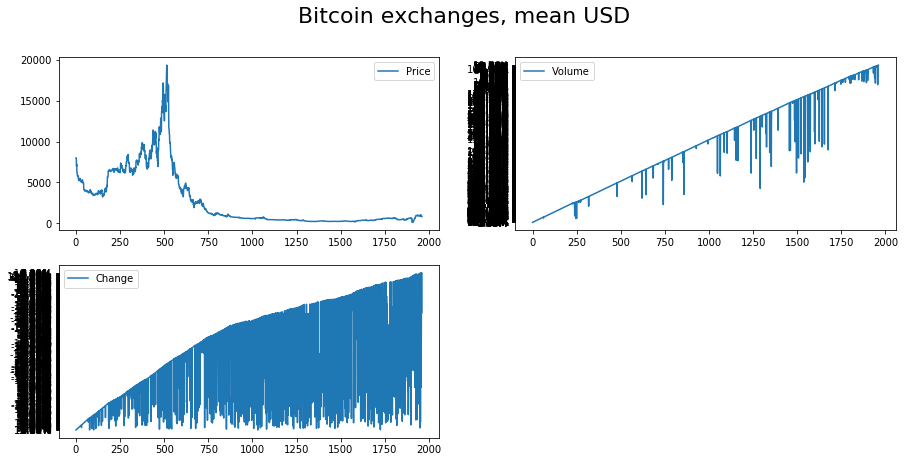

[8003.2 7994.6 7806.  ...  884.3  856.9  815.9]
train test lengths:
1372 589
1371
588
Instructions for updating:
Colocations handled automatically by placer.


2019-06-04 09:49:48,650 : WARNING : From /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-06-04 09:49:49,050 : WARNING : From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1371 samples, validate on 588 samples
Epoch 1/500
 - 1s - loss: 0.0642 - val_loss: 9.4150e-04
Epoch 2/500
 - 0s - loss: 0.0485 - val_loss: 0.0040
Epoch 3/500
 - 0s - loss: 0.0387 - val_loss: 0.0083
Epoch 4/500
 - 0s - loss: 0.0323 - val_loss: 0.0127
Epoch 5/500
 - 0s - loss: 0.0281 - val_loss: 0.0160
Epoch 6/500
 - 0s - loss: 0.0253 - val_loss: 0.0178
Epoch 7/500
 - 0s - loss: 0.0231 - val_loss: 0.0182
Epoch 8/500
 - 0s - loss: 0.0213 - val_loss: 0.0177
Epoch 9/500
 - 0s - loss: 0.0197 - val_loss: 0.0167
Epoch 10/500
 - 0s - loss: 0.0181 - val_loss: 0.0156
Epoch 11/500
 - 0s - loss: 0.0166 - val_loss: 0.0144
Epoch 12/500
 - 0s - loss: 0.0151 - val_loss: 0.0131
Epoch 13/500
 - 0s - loss: 0.0137 - val_loss: 0.0119
Epoch 14/500
 - 0s - loss: 0.0122 - val_loss: 0.0106
Epoch 15/500
 - 0s - loss: 0.0108 - val_loss: 0.0094
Epoch 16/500
 - 0s - loss: 0.0094 - val_loss: 0.0082
Epoch 17/500
 - 0s - loss: 0.0081 - val_loss: 0.0070
Epoch 18/500
 - 0s - loss: 0.0069 - val_loss: 0.0060
Epoc

Epoch 138/500
 - 0s - loss: 2.2633e-04 - val_loss: 3.8709e-06
Epoch 139/500
 - 0s - loss: 2.2611e-04 - val_loss: 3.8184e-06
Epoch 140/500
 - 0s - loss: 2.2589e-04 - val_loss: 3.7671e-06
Epoch 141/500
 - 0s - loss: 2.2568e-04 - val_loss: 3.7169e-06
Epoch 142/500
 - 0s - loss: 2.2546e-04 - val_loss: 3.6677e-06
Epoch 143/500
 - 0s - loss: 2.2525e-04 - val_loss: 3.6199e-06
Epoch 144/500
 - 0s - loss: 2.2504e-04 - val_loss: 3.5723e-06
Epoch 145/500
 - 0s - loss: 2.2483e-04 - val_loss: 3.5265e-06
Epoch 146/500
 - 0s - loss: 2.2462e-04 - val_loss: 3.4812e-06
Epoch 147/500
 - 0s - loss: 2.2442e-04 - val_loss: 3.4376e-06
Epoch 148/500
 - 0s - loss: 2.2422e-04 - val_loss: 3.3943e-06
Epoch 149/500
 - 0s - loss: 2.2402e-04 - val_loss: 3.3524e-06
Epoch 150/500
 - 0s - loss: 2.2382e-04 - val_loss: 3.3115e-06
Epoch 151/500
 - 0s - loss: 2.2363e-04 - val_loss: 3.2714e-06
Epoch 152/500
 - 0s - loss: 2.2344e-04 - val_loss: 3.2323e-06
Epoch 153/500
 - 0s - loss: 2.2325e-04 - val_loss: 3.1944e-06
Epoch 15

 - 0s - loss: 2.1444e-04 - val_loss: 2.4501e-06
Epoch 271/500
 - 0s - loss: 2.1444e-04 - val_loss: 2.4528e-06
Epoch 272/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4562e-06
Epoch 273/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4595e-06
Epoch 274/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4621e-06
Epoch 275/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4649e-06
Epoch 276/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4684e-06
Epoch 277/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4713e-06
Epoch 278/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4733e-06
Epoch 279/500
 - 0s - loss: 2.1442e-04 - val_loss: 2.4765e-06
Epoch 280/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4803e-06
Epoch 281/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4821e-06
Epoch 282/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4839e-06
Epoch 283/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4883e-06
Epoch 284/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4914e-06
Epoch 285/500
 - 0s - loss: 2.1443e-04 - val_loss: 2.4916e-06
Epoch 286/500
 - 0s - 

Epoch 403/500
 - 0s - loss: 2.1423e-04 - val_loss: 2.4591e-06
Epoch 404/500
 - 0s - loss: 2.1423e-04 - val_loss: 2.4665e-06
Epoch 405/500
 - 0s - loss: 2.1424e-04 - val_loss: 2.4683e-06
Epoch 406/500
 - 0s - loss: 2.1425e-04 - val_loss: 2.4612e-06
Epoch 407/500
 - 0s - loss: 2.1424e-04 - val_loss: 2.4674e-06
Epoch 408/500
 - 0s - loss: 2.1425e-04 - val_loss: 2.4759e-06
Epoch 409/500
 - 0s - loss: 2.1428e-04 - val_loss: 2.4652e-06
Epoch 410/500
 - 0s - loss: 2.1426e-04 - val_loss: 2.4652e-06
Epoch 411/500
 - 0s - loss: 2.1426e-04 - val_loss: 2.4835e-06
Epoch 412/500
 - 0s - loss: 2.1430e-04 - val_loss: 2.4740e-06
Epoch 413/500
 - 0s - loss: 2.1428e-04 - val_loss: 2.4594e-06
Epoch 414/500
 - 0s - loss: 2.1426e-04 - val_loss: 2.4866e-06
Epoch 415/500
 - 0s - loss: 2.1433e-04 - val_loss: 2.4923e-06
Epoch 416/500
 - 0s - loss: 2.1432e-04 - val_loss: 2.4535e-06
Epoch 417/500
 - 0s - loss: 2.1426e-04 - val_loss: 2.4761e-06
Epoch 418/500
 - 0s - loss: 2.1434e-04 - val_loss: 2.5233e-06
Epoch 41

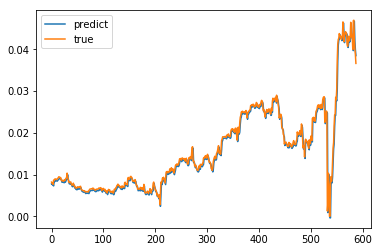

In [18]:
lstm = LSTMClassifier()
lstm.setData(btcData.data)
lstm.showInfo()

lstm.scale()
lstm.split()
lstm.classify()

plt.plot(lstm.predict, label='predict')
plt.plot(lstm.testY, label='true')
plt.legend()
plt.show()


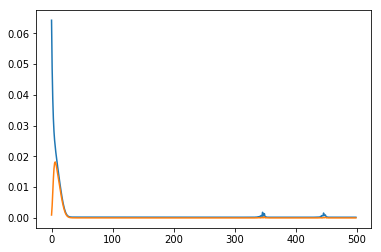

In [19]:
plt.plot(lstm.history.history['loss'], label='train')
plt.plot(lstm.history.history['val_loss'], label='test')

In [ ]:
# class TechnicalIndicatorsBuilder:

In [ ]:
# class Knyar: